In [9]:
import numpy as np
import pandas as pd
import networkx as nx


from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm


In [8]:
#preparing the data

X_df = pd.read_csv('../../data/presence_matrices/Campylobacter_coli_presence_absence.csv', index_col=0)
y_df= pd.read_csv('../../data/phenotypes/Campylobacter_coli_ciprofloxacin.csv', index_col=0)

for gene in X_df.columns:
    if X_df[gene].std() == 0:
        X_df.drop(gene, axis=1, inplace=True)

X_df = X_df.sort_index()
y_df = y_df.sort_index()

y_indices=list(y_df.index)
X_indices=list(X_df.index)

#intersection
intersection = [i for i in y_indices if i in X_indices]
y_df = y_df.loc[intersection]
X_df = X_df.loc[intersection]

X = X_df.values
y = y_df.values

In [13]:
model=SGDClassifier(loss='hinge', alpha=0.0001, max_iter=1000, tol=1e-3)
model.fit(X, y)
weights = model.coef_
weights.shape
X.shape

/home/raysas/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(267, 6995)

In [23]:
#building an ensemble of 200 SVM with bootstrap and SGD+L1 regularization
n_models = 200; acc=[]; AUCs=[]
models = []
for i in range(n_models):
    model = SGDClassifier(loss='hinge', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=i)
    model.fit(X, y)
    models.append(model)

/home/raysas/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/raysas/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/raysas/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/raysas/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [24]:
weights = np.zeros((n_models, X.shape[1]))
for i, model in enumerate(models):
    weights[i] = model.coef_

In [27]:
#save weights in a csv file
weights_df = pd.DataFrame(weights, columns=X_df.columns)


In [3]:
#make weights  a df of cols = features and rows = models
weights_df = pd.read_csv('../../data/model/Campylobacter_coli_ciprofloxacin_200_SVM_weights.csv', index_col=0)

corr_SVM_models= weights_df.corr()

In [5]:
corr_SVM_models

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,...,Cluster 8011,Cluster 8012,Cluster 8013,Cluster 8014,Cluster 8015,Cluster 8016,Cluster 8017,Cluster 8018,Cluster 8019,Cluster 8020
Cluster 0,1.000000,-0.294201,0.319087,-0.119522,-0.415325,0.339563,-0.216127,0.033138,0.123683,-0.501869,...,-0.124900,0.002263,-0.074914,-0.045997,0.183417,-0.124900,-0.124900,-0.107380,0.059141,-0.109843
Cluster 1,-0.294201,1.000000,-0.223327,0.235416,0.179638,-0.220302,-0.028859,-0.061672,-0.163276,0.199992,...,0.115677,0.055619,0.088475,0.048517,0.111975,0.115677,0.115677,0.070286,0.077906,-0.027895
Cluster 2,0.319087,-0.223327,1.000000,-0.135885,-0.088067,0.371774,0.079459,0.047693,0.208598,-0.279846,...,0.022906,-0.168044,-0.055754,-0.055462,-0.028421,0.022906,0.022906,-0.132139,0.014241,-0.081599
Cluster 3,-0.119522,0.235416,-0.135885,1.000000,0.049871,-0.175060,-0.093142,-0.055860,-0.184209,0.197759,...,0.004492,-0.006179,-0.000853,-0.013022,0.003961,0.004492,0.004492,0.088219,-0.045950,0.010851
Cluster 4,-0.415325,0.179638,-0.088067,0.049871,1.000000,-0.115409,-0.104062,0.065458,-0.038173,0.204759,...,0.194818,0.046855,0.069053,0.013208,-0.176013,0.194818,0.194818,0.059233,0.083211,0.052273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster 8016,-0.124900,0.115677,0.022906,0.004492,0.194818,-0.085627,-0.211748,-0.205658,0.038251,0.146120,...,1.000000,-0.091902,0.107403,0.071597,-0.035573,1.000000,1.000000,-0.018361,0.132710,-0.146088
Cluster 8017,-0.124900,0.115677,0.022906,0.004492,0.194818,-0.085627,-0.211748,-0.205658,0.038251,0.146120,...,1.000000,-0.091902,0.107403,0.071597,-0.035573,1.000000,1.000000,-0.018361,0.132710,-0.146088
Cluster 8018,-0.107380,0.070286,-0.132139,0.088219,0.059233,-0.091440,-0.030137,0.151829,-0.095097,0.145279,...,-0.018361,-0.103336,-0.009532,0.084958,-0.070850,-0.018361,-0.018361,1.000000,-0.060517,0.084649
Cluster 8019,0.059141,0.077906,0.014241,-0.045950,0.083211,-0.097104,-0.041767,0.076796,-0.218591,0.019696,...,0.132710,-0.027361,0.012295,-0.084208,-0.012939,0.132710,0.132710,-0.060517,1.000000,-0.019112


In [5]:
G=nx.Graph()

for i in range(X.shape[1]):
    for j in range(i+1, X.shape[1]):
        correlation = corr_SVM_models.iloc[i, j]
        if correlation > 0.6 or corr_SVM_models.iloc[j, i] < -0.6:
            G.add_edge(i, j, weight=correlation)

In [2]:
# save G in grahpml
# nx.write_graphml(G, '../../data/graphs-4/signed_corr0.6_200SVM_Campylobacter_coli_ciprofloxacin.graphml')

G=nx.read_graphml('../../data/graphs-4/signed_corr0.6_200SVM_Campylobacter_coli_ciprofloxacin.graphml')

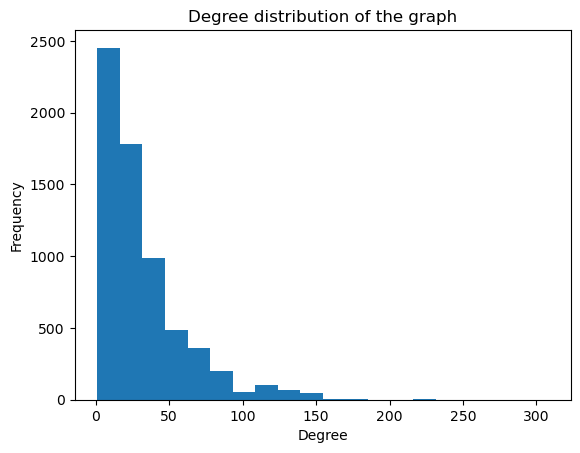

In [7]:
#draw teh degree distribution
import matplotlib.pyplot as plt
degrees = [d for n, d in G.degree()]
plt.hist(degrees, bins=20)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution of the graph')
plt.show()

In [8]:
G.number_of_edges()

102065

In [9]:
edges_list=list(G.edges())

In [ ]:
edges_list

In [10]:
edges_list=[(0,75)]

for pair in edges_list:
    i,j = pair
    X_sel=X[: [i, j]]
    X_selected = sm.add_constant(X_selected)
    X_selected['interaction'] = X_selected.iloc[:, 1] * X_selected.iloc[:, 2]
    logit_model = sm.Logit(y, X_selected)
    result = logit_model.fit()

coefficients = result.params
p_values = result.pvalues
result.summary()


TypeError: slice indices must be integers or None or have an __index__ method

In [11]:
G=nx.Graph(); graphs={}

for t in range(1,10):
    t/=10
    t=round(t,1) #making sure only one significant figure
    for i in range(X.shape[1]):
        for j in range(i+1, X.shape[1]):
            correlation = corr_SVM_models.iloc[i, j]
            if correlation > t or corr_SVM_models.iloc[j, i] < -t:
                G.add_edge(i, j, weight=correlation)
    print(f"done with {t}")
    graphs[f'corr {t}']=G